In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import struct
import os

import numpy as np
import os
import warnings
import random
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from collections import Counter

from sklearn.metrics import accuracy_score
from sklearn.linear_model import RidgeClassifierCV
from sklearn.pipeline import make_pipeline
import pywt

from data_split import *
from data_process import *

In [6]:
zwy_dig_10 = get_specific_data('E:/研一/嗑盐/土壤扰动/dataset/zwy', by_txt=False)
zwy1_dig_10 = get_specific_data('E:/研一/嗑盐/土壤扰动/dataset/zwy_d1', by_txt=False)
zwy2_dig_10 = get_specific_data('E:/研一/嗑盐/土壤扰动/dataset/zwy_md', by_txt=False)
zwy_jump_10 = get_specific_data('E:/研一/嗑盐/土壤扰动/dataset/zwy', by_txt=False, activity='jump')
zwy1_jump_10 = get_specific_data('E:/研一/嗑盐/土壤扰动/dataset/zwy_d1', by_txt=False, activity='jump')
zwy2_jump_10 = get_specific_data('E:/研一/嗑盐/土壤扰动/dataset/zwy_md', by_txt=False, activity='jump')

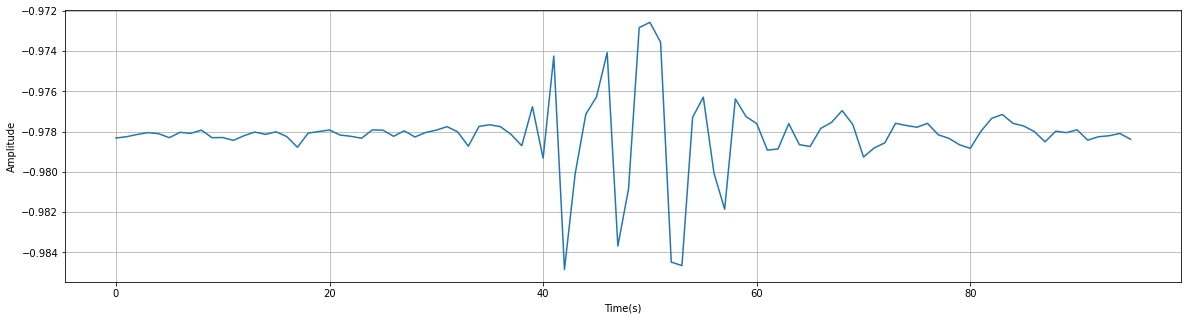

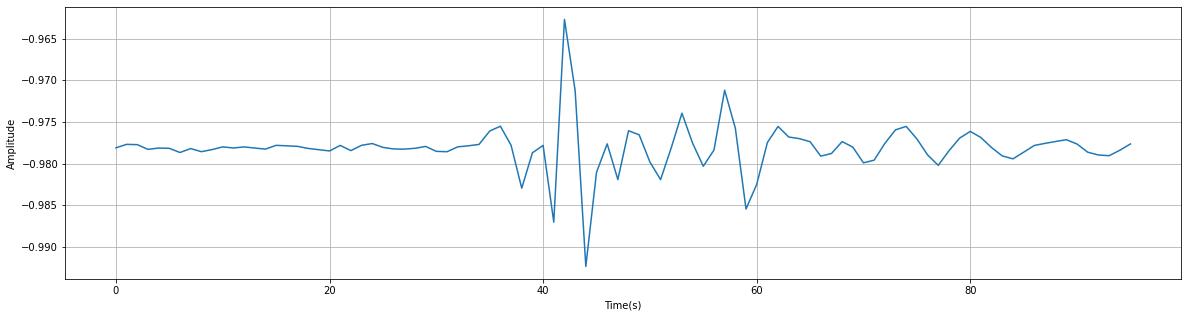

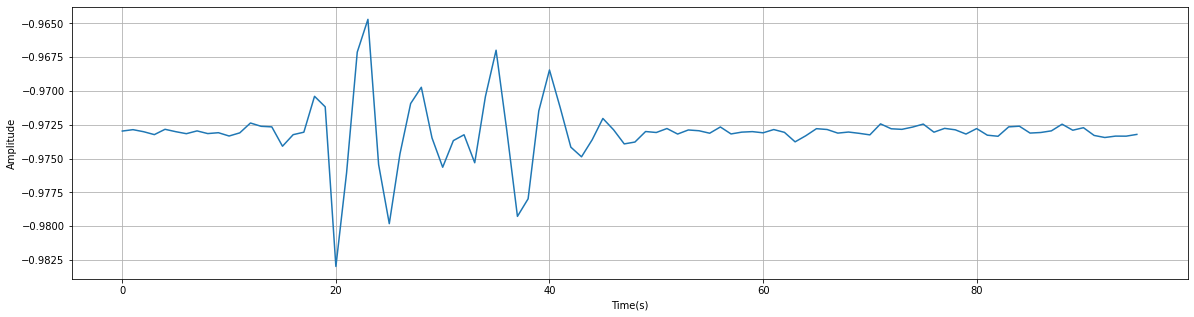

In [8]:
plot_time(zwy_dig_10[1]['data_z'])
plot_time(zwy1_dig_10[1]['data_z'])
plot_time(zwy2_dig_10[1]['data_z'])

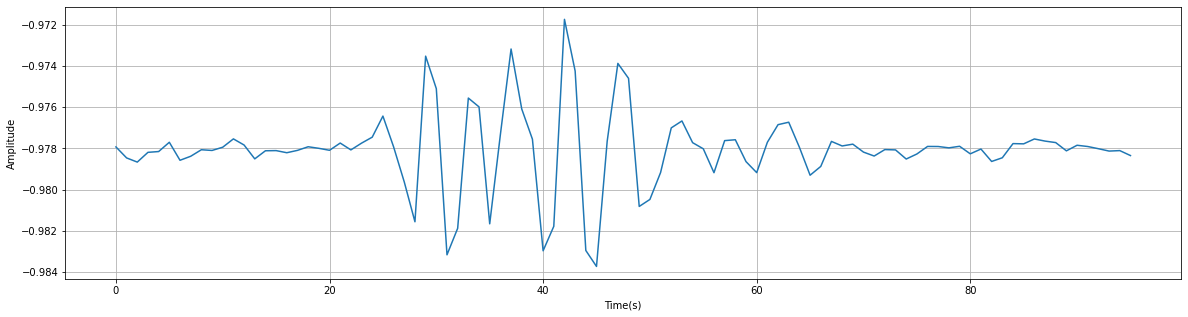

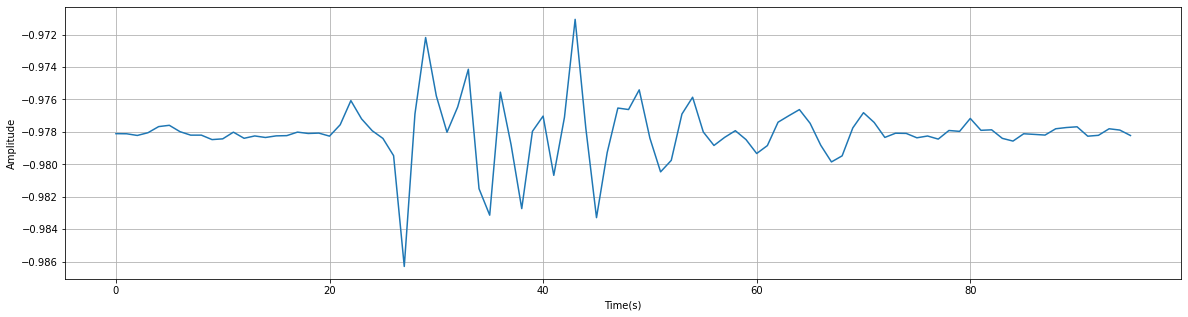

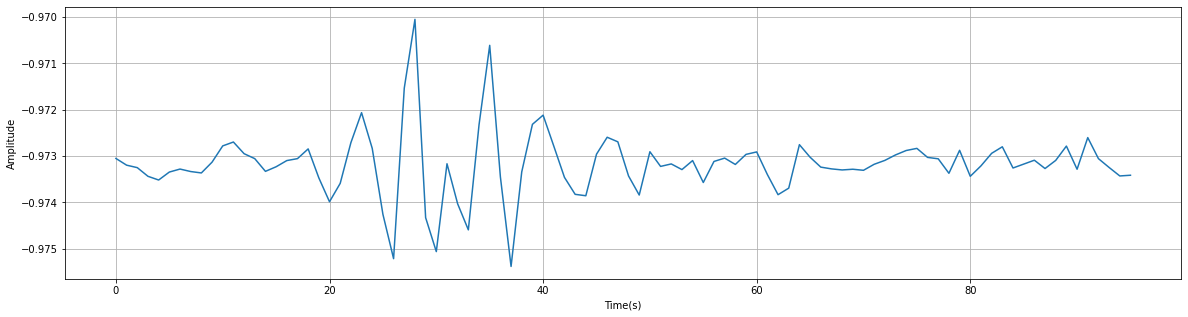

In [9]:
plot_time(zwy_jump_10[1]['data_z'])
plot_time(zwy1_jump_10[1]['data_z'])
plot_time(zwy2_jump_10[1]['data_z'])

In [21]:
def get_wt_features(signal, level=4):
    """指定某一轴的信号，进行小波分解，获取特征
    """
    features = []
    wp = pywt.WaveletPacket(data=signal, wavelet='db3', mode='symmetric', maxlevel=level)
    for node in wp.get_level(level, 'freq'):
        data = wp[node.path].data
        features.append(data)
    
    return np.array(features, dtype=np.float64)

In [22]:
def process_wavelet(data, level=4):
    """给波形的三轴都计算小波特征，最后合并成特征图
    data: {'data_x': ..., 'data_y': ..., 'data_z': ..., ....}
    """
    sig_x, sig_y, sig_z = data['data_x'], data['data_y'], data['data_z']
    wt_x, wt_y, wt_z = get_wt_features(sig_x), get_wt_features(sig_y), get_wt_features(sig_z)
    return np.array([wt_x, wt_y, wt_z])

In [18]:
origin_x = train_dataset_zwy[0]['data_x']
wavelet_features = get_wavelet_features(origin_x, 3)

In [20]:
wavelet_features.shape

(8, 16)

In [75]:
import numpy as np
import matplotlib.pyplot as plt
from pyts.datasets import load_gunpoint
from pyts.transformation import ShapeletTransform
from pyts.classification import LearningShapelets
from pyts.image import MarkovTransitionField, GramianAngularField

In [16]:
# Toy dataset
X_train, _, y_train, _ = load_gunpoint(return_X_y=True)
zwy1_dig_10 = get_specific_data('E:/研一/嗑盐/土壤扰动/dataset/zwy_d1', by_txt=False)
zwy_dig_10 = get_specific_data('E:/研一/嗑盐/土壤扰动/dataset/zwy', by_txt=False)

In [17]:
# Shapelet transformation
st = ShapeletTransform(window_sizes=[12, 24, 36, 48],
                       random_state=42, sort=True)
X_new = st.fit_transform(X_train, y_train)

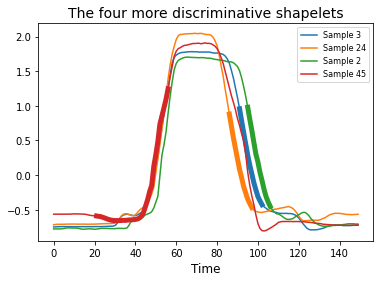

In [23]:
# Visualize the four most discriminative shapelets
plt.figure(figsize=(6, 4))
for i, index in enumerate(st.indices_[:4]):
    idx, start, end = index
    plt.plot(X_train[idx], color='C{}'.format(i),
             label='Sample {}'.format(idx))
    plt.plot(np.arange(start, end), X_train[idx, start:end],
             lw=5, color='C{}'.format(i))

plt.xlabel('Time', fontsize=12)
plt.title('The four more discriminative shapelets', fontsize=14)
plt.legend(loc='best', fontsize=8)
plt.show()

In [32]:
zwy_dig_10 = get_specific_data('E:/研一/嗑盐/土壤扰动/dataset/zwy', by_txt=False)
zwy_jump_10 = get_specific_data('E:/研一/嗑盐/土壤扰动/dataset/zwy', activity='jump', by_txt=False)
zwy_walk_10 = get_specific_data('E:/研一/嗑盐/土壤扰动/dataset/zwy', activity='walk', by_txt=False)

total_data = zwy_dig_10 + zwy_jump_10 + zwy_walk_10
random.shuffle(total_data)
train_data = [item['data_z'] for item in total_data]
train_label = [item['label'] for item in total_data]

In [38]:
clf = LearningShapelets(random_state=42, tol=0.01)
clf.fit(train_data, train_label)

LearningShapelets(random_state=42, tol=0.01)

In [44]:
zwy1_dig_10 = get_specific_data('E:/研一/嗑盐/土壤扰动/dataset/zwy_d1', by_txt=False)
zwy1_jump_10 = get_specific_data('E:/研一/嗑盐/土壤扰动/dataset/zwy_d1', activity='jump', by_txt=False)
zwy1_walk_10 = get_specific_data('E:/研一/嗑盐/土壤扰动/dataset/zwy_d1', activity='walk', by_txt=False)

total_data = zwy_dig_10 + zwy_jump_10 + zwy_walk_10
test_data = [item['data_z'] for item in total_data]
test_label = [item['label'] for item in total_data]

In [45]:
clf.score(test_data, test_label)

0.3858267716535433

In [39]:
# Select two shapelets
shapelets = np.asarray([clf.shapelets_[0, -9], clf.shapelets_[0, -12]])

# Derive the distances between the time series and the shapelets
shapelet_size = shapelets.shape[1]
X_window = windowed_view(X, window_size=shapelet_size, window_step=1)
X_dist = np.mean(
    (X_window[:, :, None] - shapelets[None, :]) ** 2, axis=3).min(axis=1)

plt.figure(figsize=(14, 4))

# Plot the two shapelets
plt.subplot(1, 2, 1)
plt.plot(shapelets[0])
plt.plot(shapelets[1])
plt.title('Two learned shapelets', fontsize=14)

array([-0.98033667, -0.97657219, -0.97325397, -0.97628368, -0.98179175,
       -0.9818547 , -0.97744819, -0.97518867, -0.97688673, -0.97895279,
       -0.97909298, -0.9790287 , -0.97790302, -0.97679998, -0.97729248,
       -0.9784556 , -0.97892964, -0.97847257, -0.97803603, -0.97784278,
       -0.97775595, -0.97784513, -0.97811806, -0.97835758, -0.97831057,
       -0.97812027, -0.97799751, -0.97797075, -0.97790899, -0.97790864])

In [76]:
gaf = GramianAngularField(image_size=24)
# train_mtf = mtf.fit_transform(train_data)

In [78]:
def draw_gaf(x, gaf):
    x = x.reshape(1, -1)
    X = gaf.transform(x)
    plt.figure(figsize=(5, 5))
    plt.imshow(X[0], cmap='rainbow', origin='lower')
    plt.title('Markov Transition Field', fontsize=18)
    plt.colorbar(fraction=0.0457, pad=0.04)
    plt.tight_layout()
    plt.show()


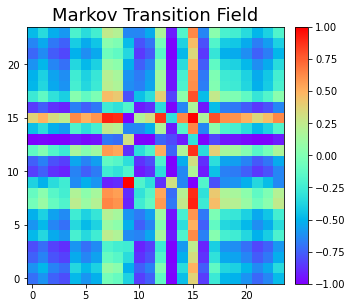

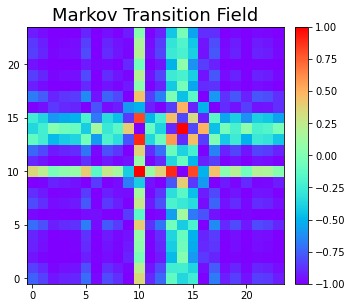

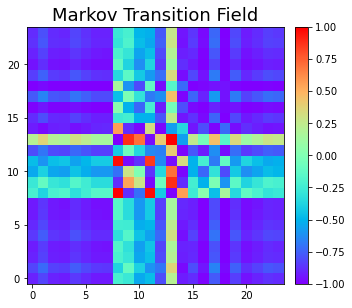

In [84]:
draw_gaf(zwy_dig_10[4]['data_z'], gaf)
draw_gaf(zwy_jump_10[4]['data_z'], gaf)
draw_gaf(zwy_walk_10[4]['data_z'], gaf)

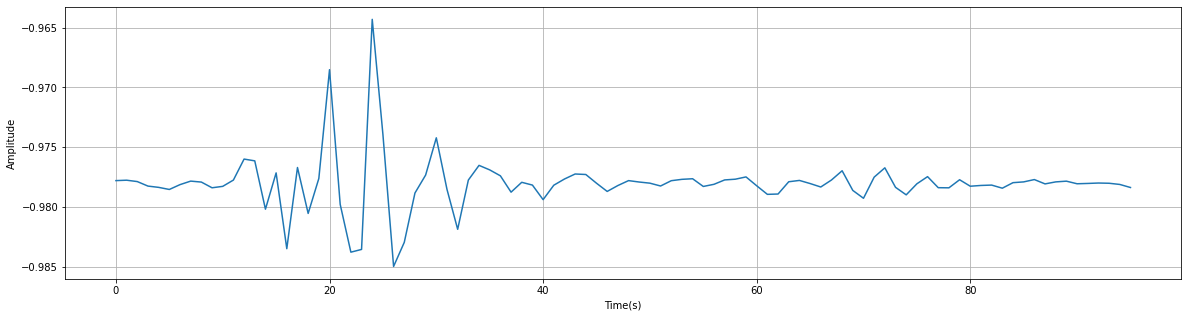

In [86]:
plot_time(zwy_dig_10[0]['data_z'])

In [111]:
def mmse(sig, a=0.98):
    temp = np.array([sig[0]-a*sig[0]])

    return np.append(sig[0]-a*sig[0], sig[1:]-a*sig[:-1])

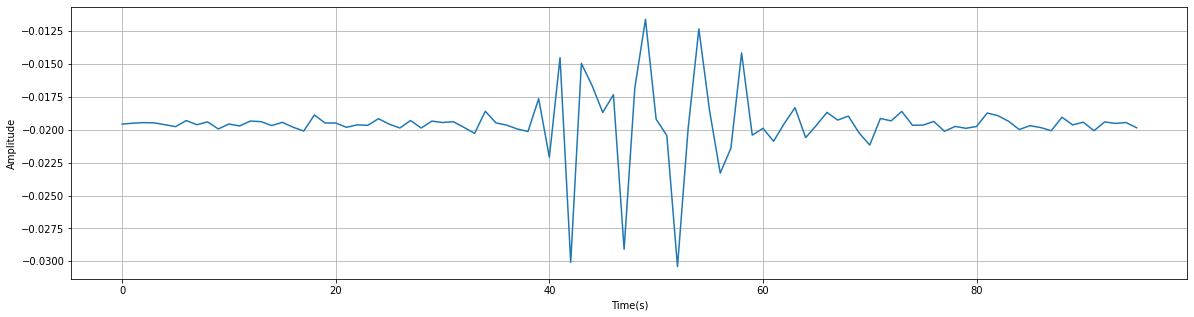

In [127]:
plot_time(mmse(zwy_dig_10[1]['data_z']))

In [120]:
from scipy.signal import hilbert, chirp

In [122]:
fs = 500
signal = mmse(zwy_dig_10[7]['data_z'])
analytic_signal = hilbert(signal)
amplitude_envelope = np.abs(analytic_signal)
instantaneous_phase = np.unwrap(np.angle(analytic_signal))
instantaneous_frequency = (np.diff(instantaneous_phase) /
                           (2.0*np.pi) * fs)

(0.0, 120.0)

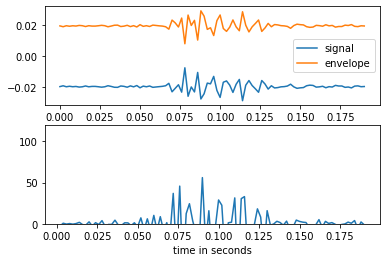

In [125]:
t = np.arange(len(signal)) / fs
fig = plt.figure()
ax0 = fig.add_subplot(211)
ax0.plot(t, signal, label='signal')
ax0.plot(t, amplitude_envelope, label='envelope')
ax0.set_xlabel("time in seconds")
ax0.legend()
ax1 = fig.add_subplot(212)
ax1.plot(t[1:], instantaneous_frequency)
ax1.set_xlabel("time in seconds")
ax1.set_ylim(0.0, 120.0)